# Statistics

In [1]:
%load_ext autoreload
%autoreload 2

## Graph statistics

In [ ]:
import graph_helper
import dataset_helper
import matplotlib.pyplot as plt
from IPython.display import display

for graph_cache_file in dataset_helper.get_all_cached_graph_datasets():
    if 'ana' in graph_cache_file: continue
    if 'gml' not in graph_cache_file: continue
    cache_filename = graph_cache_file.split('/')[-1]
    print('{} {}'.format('#' * 20, cache_filename))
    X, Y = dataset_helper.get_dataset_cached(graph_cache_file)
    num_classes = min(len(set(X)), 20)
    #dataset_helper.plot_dataset_class_distribution(X, Y, title = graph_cache_file, figsize=(12, num_classes * 0.8))
    df = graph_helper.get_graph_stats(X, Y)
    
    ax = df['num_graphs'].plot.barh(title = 'Graphs per topic\n(Dataset: {})'.format(cache_filename.replace('.npy', '')), legend = True, figsize = (14, 8))
    ax.set_xlabel('# graphs')
    display(df)
    plt.show()
    break

In [30]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

df_all = None
for result_file in glob('data/results/*.npy'):
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 4)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    if is_graph_dataset:
        result['wl_iteration'] = int(dataset.split('.')[-1])
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            #result['window_size'] = -1
            dataset_name = parts[3].split('.')[0]
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
    for param in result['params']:
        del param['clf']
    if dataset_name.endswith('-single'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    result['dataset'] = dataset_name
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    
    if df_all is None:
        df_all = result_df
    else:
        df_all = df_all.append(result_df)

#df_graphs = df_all[df_all.set_type == 'graph']
#df_texts = df_all[df_all.set_type == 'text']
df_all['window_size'].fillna('concept-graph', inplace = True)
df_all['wl_iteration'] = df_all.wl_iteration.astype(int, errors = 'ignore')
df_all['type']

0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
0     cooccurrence
         ...      
0    concept-graph
0    concept-graph
0    concept-graph
0    concept-graph
0    concept-graph
0    concept-graph
0    concept-graph
0    concept-graph
0             text
1             text
0             text
1             text
0             text
1             text
0             text
1             text
0             text
1             text
0             text
1             text
0             text
1           

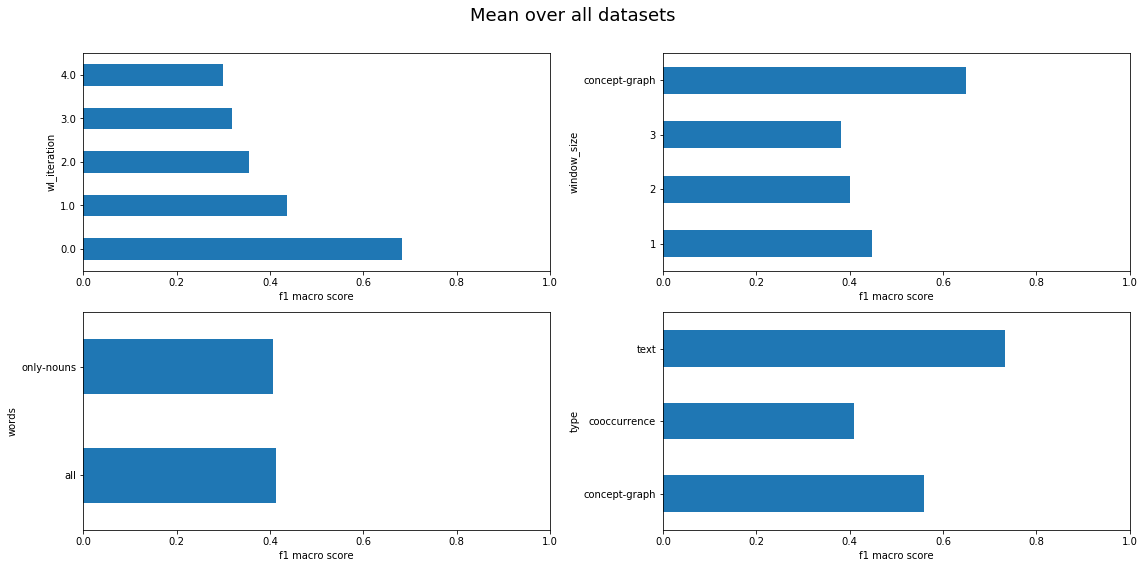

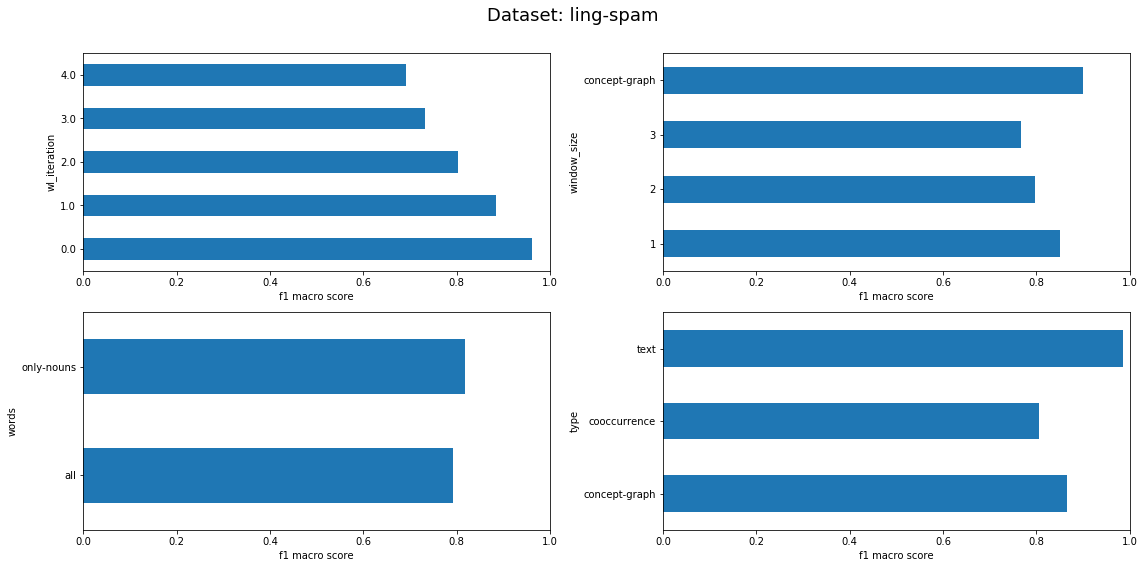

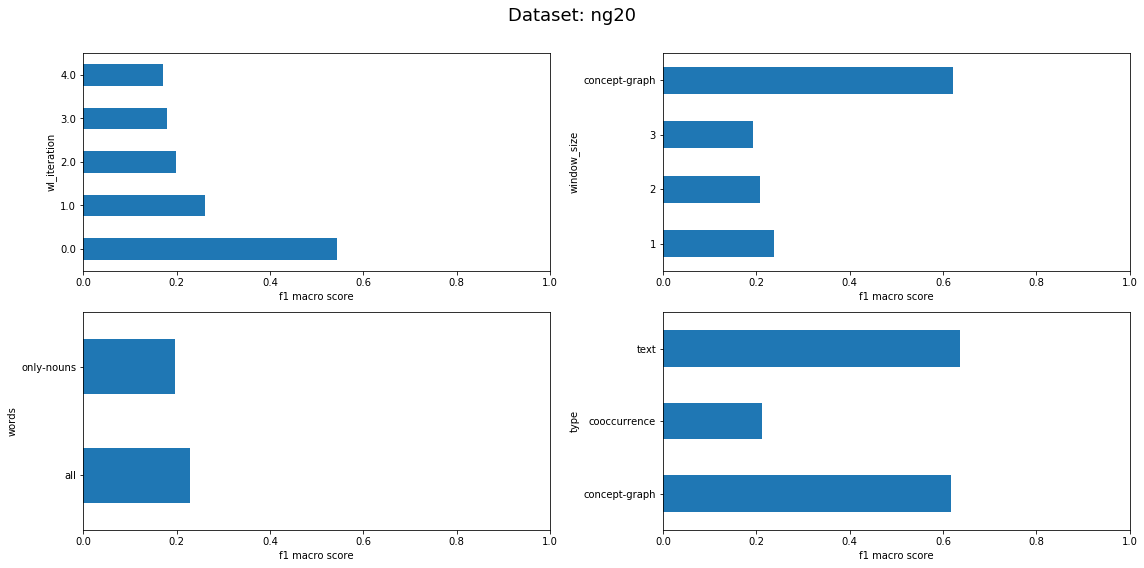

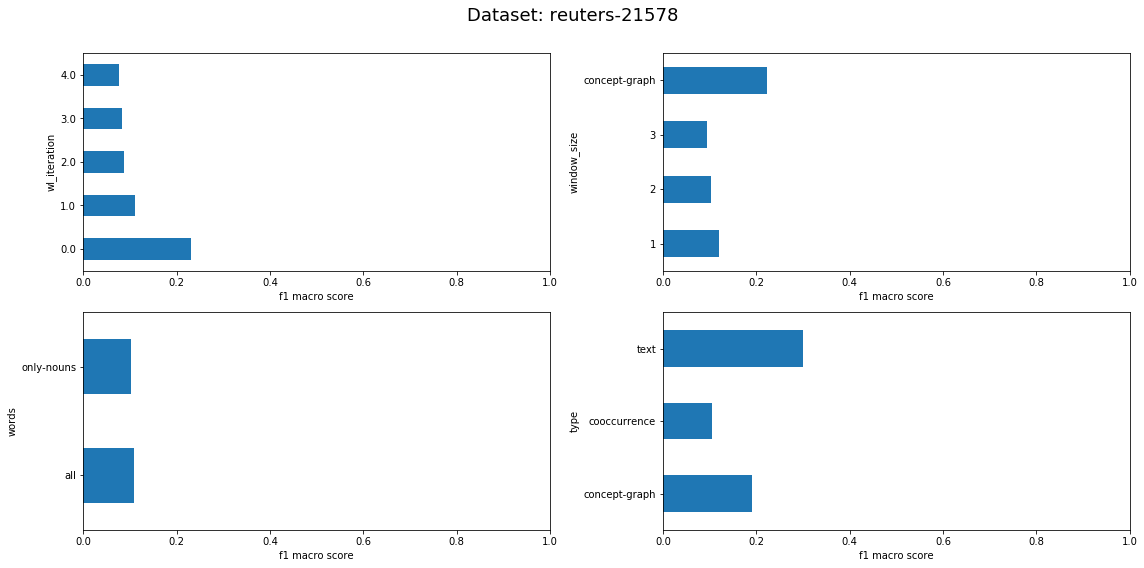

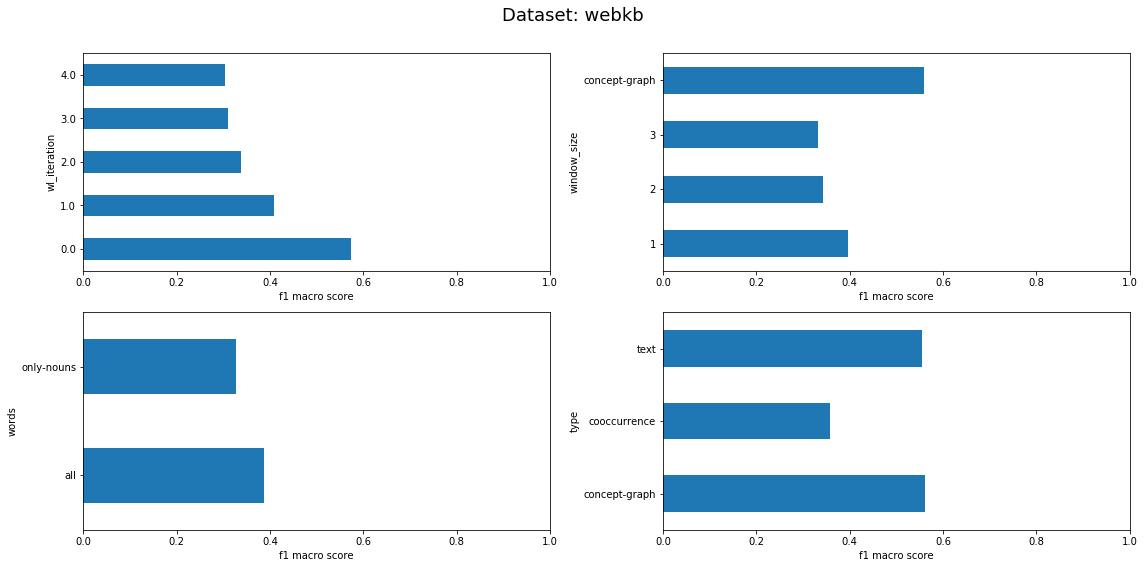

In [36]:
def plot_distributions(df, title = None):
    fig, axes_indexed = plt.subplots(nrows = 2, ncols=2, figsize = (16, 8))

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type'], axes):
        df.groupby(val).mean_test_score.mean().plot(kind = 'barh', ax = ax, xlim = (0, 1))
        ax.set_xlabel('f1 macro score')
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)

plot_distributions(df_all, title = 'Mean over all datasets')
plt.show()
for name, df_dataset in df_all.groupby('dataset'):
    if len(df_dataset.type.value_counts()) < 3:
        continue
    plot_distributions(df_dataset, title = 'Dataset: {}'.format(name))
    plt.show()


In [4]:
import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embedding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][1][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df.mean()# .mean() #.mean().to_frame()

webkb
	GoogleNews-vectors-negative300
		co   missing  39%
		gml  missing  93%
	glove.42B.300d
		co   missing  10%
		gml  missing  92%
	glove.6B.100d
		co   missing  28%
		gml  missing  92%
	glove.6B.200d
		co   missing  28%
		gml  missing  92%
	glove.6B.300d
		co   missing  28%
		gml  missing  92%
	glove.6B.50d
		co   missing  28%
		gml  missing  92%
	glove.840B.300d
		co   missing  18%
		gml  missing  92%
	glove.twitter.27B.100d
		co   missing  22%
		gml  missing  93%
	glove.twitter.27B.200d
		co   missing  22%
		gml  missing  93%
	glove.twitter.27B.25d
		co   missing  22%
		gml  missing  93%
	glove.twitter.27B.50d
		co   missing  22%
		gml  missing  93%
	trained
		co   missing  28%
		gml  missing  91%
ng20-ana
r8
cade-ana
ling-spam
	GoogleNews-vectors-negative300
		co   missing  56%
		gml  missing  92%
	glove.42B.300d
		co   missing  20%
		gml  missing  90%
	glove.6B.100d
		co   missing  36%
		gml  missing  90%
	glove.6B.200d
		co   missing  36%
		gml  missing  90%
	glove.6B.300d
		c

GoogleNews-vectors-negative300    93.50
glove.42B.300d                    91.50
glove.6B.100d                     92.00
glove.6B.200d                     92.00
glove.6B.300d                     92.00
glove.6B.50d                      92.00
glove.840B.300d                   92.00
glove.twitter.27B.100d            92.75
glove.twitter.27B.200d            92.75
glove.twitter.27B.25d             92.75
glove.twitter.27B.50d             92.75
trained                           91.00
dtype: float64